# **Library Installation**

In [1]:
# Library
# !pip install pyswarms
from pyswarm import pso
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
# Set seed
np.random.seed(42)

# **Read Data**

In [3]:
# Load dataset
df = pd.read_excel('XCleanCryptocurrencyDataset.xlsx', index_col=0)
display(df)

,full_text,processed_text,vader_sentiment
0,'Token: $GROK24 - Grok 2024 Network: Ethereum ...,token grok grok network ethereum contract xccc...,Positive
1,@metaversejoji Let's check @SolanaMono $SOL #W...,let check sol,Negative
2,"Day's DCA: $BTC, $ATOM, $DVPN, $AXL, $JKL, $HU...",day dca btc atom dvpn axl jkl huahua,Negative
3,@BorkSOL @Cerita_Crypto @solana @aeyakovenko Y...,project really amazing thats followed send please,Positive
4,👉 WL FOR .0 SOL MINT 👈 👉40 HOURS TILL SNAPSHOT...,sol mint hour till snapshot requirement join d...,Positive
...,...,...,...
9879,CyberKong VX #11328 was adopted for 0.18 $ETH...,cyberkong adopted eth blur,Negative
9880,BULLISH ON SOLANA BULLISH ON JUP BULLISH ON MA...,bullish solana bullish jup bullish madlads,Negative
9881,@naija_bitcoin 🍿🍿🍿🍿🍿 rd to 3k before valentine...,valentine,Negative
9882,Binance Futures #KLAY/ #USDT Take-Profit targe...,binance future takeprofit target profit period...,Positive


# **Data Splitting**

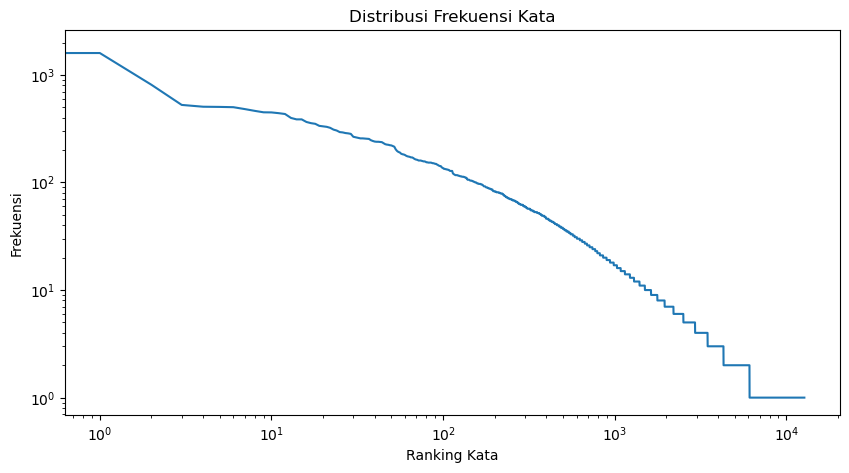

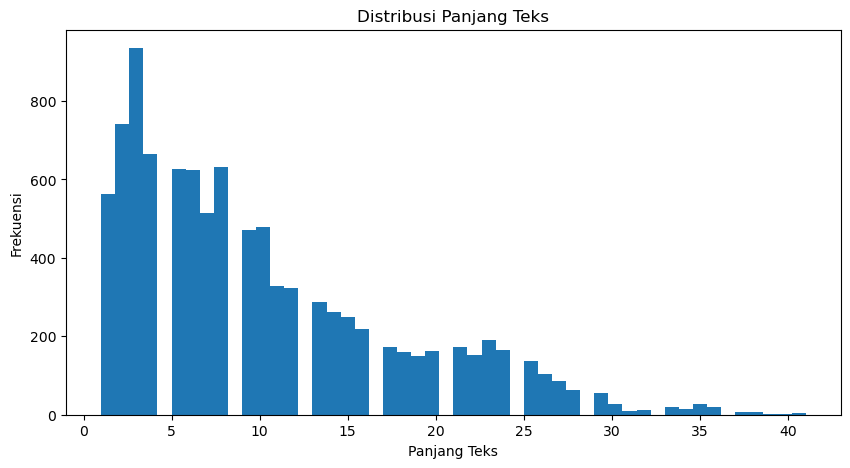

In [4]:
# Asumsikan df adalah DataFrame Anda yang sudah dimuat
X = df['processed_text']  # Kolom teks yang sudah diproses
y = df['vader_sentiment']  # Target/Label

# Encoding target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Analisis Frekuensi Kata
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Plot distribusi frekuensi kata
plt.figure(figsize=(10, 5))
plt.loglog([x[1] for x in sorted_word_counts])  # Log-log plot
plt.ylabel('Frekuensi')
plt.xlabel('Ranking Kata')
plt.title('Distribusi Frekuensi Kata')
plt.show()

# Tentukan num_words
cumulative_coverage = np.cumsum([x[1] for x in sorted_word_counts]) / sum(word_counts.values())
num_words = np.searchsorted(cumulative_coverage, 0.95) + 1  # Misal, menutupi 95% frekuensi total

# Analisis Panjang Teks
text_lengths = [len(text.split()) for text in X]
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50)
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Teks')
plt.show()

# Tentukan maxlen
maxlen = np.percentile(text_lengths, 95)  # Misal, persentil ke-95

# Tokenisasi dan pembuatan sequences
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(sequences, maxlen=int(maxlen))  # Sesuaikan maxlen sesuai dengan kebutuhan default:100

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [5]:
# Asumsikan y adalah target/label Anda
y = df['vader_sentiment']  # Contoh target/Label

# Encoding target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menampilkan label kelas dan encoding-nya
labels = label_encoder.classes_
print("Label kelas dan encoding-nya:")
for i, label in enumerate(labels):
    print(f"Kelas {i}: {label}")

Label kelas dan encoding-nya:
Kelas 0: Negative
Kelas 1: Positive


# **Model**

In [6]:
def objective_function(params):
    num_lstm_units = int(params[0])  # Extract the optimized number of LSTM units
    model = create_lstm_model(X_train.shape[1], y_train.shape[1], num_lstm_units)
    model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)

    # Use predict method and post-process to get predicted classes
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    return -accuracy

def create_lstm_model(input_length, num_classes, num_lstm_units):
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=300, input_length=input_length),
        LSTM(num_lstm_units, dropout=0.2, recurrent_dropout=0.2),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')  # Gunakan 'sigmoid' untuk binary, 'softmax' untuk multiclass
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy', metrics=['accuracy'])  # Sesuaikan loss function
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Bounds
lb = [16]  # Lower bound for LSTM units
ub = [256]  # Upper bound for LSTM units

# **Feature Selection**

# Particle Swarm Optimization (PSO)

In [7]:
best_solution_pso, best_score_pso = pso(func=objective_function, lb=lb, ub=ub, swarmsize=10, maxiter=10)
print(f"Best PSO Solution: {best_solution_pso}, Best Score: {best_score_pso}") #Best PSO Solution: [53.44447371], Best Score: -0.8649060436769934





62/62 [==============================] - 1s 7ms/step
Stopping search: maximum iterations reached --> 10
Best PSO Solution: [53.44447371], Best Score: -0.8649060436769934


# Ant Colony Optimization (ACO)

In [8]:
def aco(func, num_ants, num_iterations, lb, ub, decay=0.95, alpha=1.0, beta=1.0):
    best_score = -float('inf')  # Inisialisasi dengan nilai terburuk; gunakan -inf karena kita mencari maksimum
    best_solution = None
    # Inisialisasi level feromon
    pheromone_levels = np.ones(ub - lb) * 0.1  # Asumsikan semua path dimulai dengan level feromon yang sama dan rendah
    
    for iteration in range(num_iterations):
        # Simpan solusi dan skor untuk setiap semut
        solutions = []
        scores = []

        for ant in range(num_ants):
            # Membangun solusi berdasarkan distribusi probabilitas feromon
            p = (pheromone_levels ** alpha) * ((1.0 / (np.arange(ub - lb) + 1)) ** beta)
            p /= p.sum()  # Normalisasi probabilitas
            chosen_index = np.random.choice(np.arange(ub - lb), p=p)
            solution = lb + chosen_index
            
            # Hitung skor menggunakan fungsi objektif
            score = func([solution])  # Asumsi fungsi objektif menerima list

            solutions.append(solution)
            scores.append(score)
            
            # Perbarui solusi terbaik
            if score > best_score:
                best_score = score
                best_solution = solution

        # Perbarui level feromon untuk semua solusi
        for solution, score in zip(solutions, scores):
            pheromone_levels[solution - lb] += 1.0 / (1.0 - score)  # Update feromon berdasarkan kebaikan solusi

        # Terapkan penguapan feromon
        pheromone_levels *= decay

    return best_solution, best_score

In [9]:
best_solution_aco, best_score_aco = aco(func=objective_function, lb=lb[0], ub=ub[0], num_ants=10, num_iterations=10)
print(f"Best ACO Solution: {best_solution_aco}, Best Score: {best_score_aco}") #Best ACO Solution: 33, Best Score: -0.8450990350431691

62/62 [==============================] - 0s 3ms/step
Best ACO Solution: 33, Best Score: -0.8450990350431691


# Cat Swarm Optimization (CSO)

In [10]:
def cso(func, num_cats, num_iterations, lb, ub, mixture_ratio=0.5):
    best_score = float('inf')
    best_solution = np.random.randint(lb, ub)  # Inisialisasi best_solution dengan nilai acak yang valid
    cat_positions = np.random.randint(low=lb, high=ub, size=num_cats)  # Inisialisasi posisi kucing

    for iteration in range(num_iterations):
        for cat in range(num_cats):
            # Tentukan apakah kucing ini dalam seeking mode atau tracing mode
            if np.random.rand() < mixture_ratio:
                # Seeking Mode
                candidate_position = cat_positions[cat] + np.random.randint(-3, 4)  # Langkah acak kecil
                candidate_position = np.clip(candidate_position, lb, ub-1)  # Pastikan tetap dalam batas
            else:
                # Tracing Mode
                candidate_position = best_solution + np.random.randint(-10, 11)  # Bergerak ke arah solusi terbaik
                candidate_position = np.clip(candidate_position, lb, ub-1)
            
            candidate_score = func([candidate_position])

            # Perbarui solusi terbaik
            if candidate_score < best_score:
                best_score = candidate_score
                best_solution = candidate_position
            
            cat_positions[cat] = candidate_position

    return best_solution, -best_score  # Mengembalikan skor sebagai positif


In [11]:
best_solution_cso, best_score_cso = cso(func=objective_function, lb=lb[0], ub=ub[0], num_cats=10, num_iterations=10)
print(f"Best CSO Solution: {best_solution_cso}, Best Score: {best_score_cso}") #Best CSO Solution: 244, Best Score: 0.8643981716607415

62/62 [==============================] - 1s 21ms/step
Best CSO Solution: 244, Best Score: 0.8643981716607415


# **Modeling**

# LSTM

In [23]:
model_lstm = create_lstm_model(X_train.shape[1], y_train.shape[1], num_lstm_units=256)

start_time_lstm = time.time()
history_lstm = model_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)
end_time_lstm = time.time()
time_execution_lstm = end_time_lstm - start_time_lstm

# Evaluasi model
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_lstm}")
print(f"Test Accuracy: {accuracy_lstm}")
print(f"Time Execution: {time_execution_lstm}")

Epoch 1/10
50/50 [==============================] - 12s 189ms/step - loss: 0.6071 - accuracy: 0.6790 - val_loss: 0.4600 - val_accuracy: 0.7683
Epoch 2/10
50/50 [==============================] - 9s 177ms/step - loss: 0.2841 - accuracy: 0.8898 - val_loss: 0.3686 - val_accuracy: 0.8559
Epoch 3/10
50/50 [==============================] - 9s 182ms/step - loss: 0.1229 - accuracy: 0.9602 - val_loss: 0.4085 - val_accuracy: 0.8559
Epoch 4/10
50/50 [==============================] - 9s 183ms/step - loss: 0.0712 - accuracy: 0.9798 - val_loss: 0.5382 - val_accuracy: 0.8546
Epoch 5/10
50/50 [==============================] - 9s 182ms/step - loss: 0.0370 - accuracy: 0.9903 - val_loss: 0.5246 - val_accuracy: 0.8463
Epoch 6/10
50/50 [==============================] - 9s 183ms/step - loss: 0.0495 - accuracy: 0.9852 - val_loss: 0.5511 - val_accuracy: 0.8578
Epoch 7/10
50/50 [==============================] - 9s 183ms/step - loss: 0.0250 - accuracy: 0.9933 - val_loss: 0.7022 - val_accuracy: 0.8457
Epoch

62/62 [==============================] - 1s 15ms/step


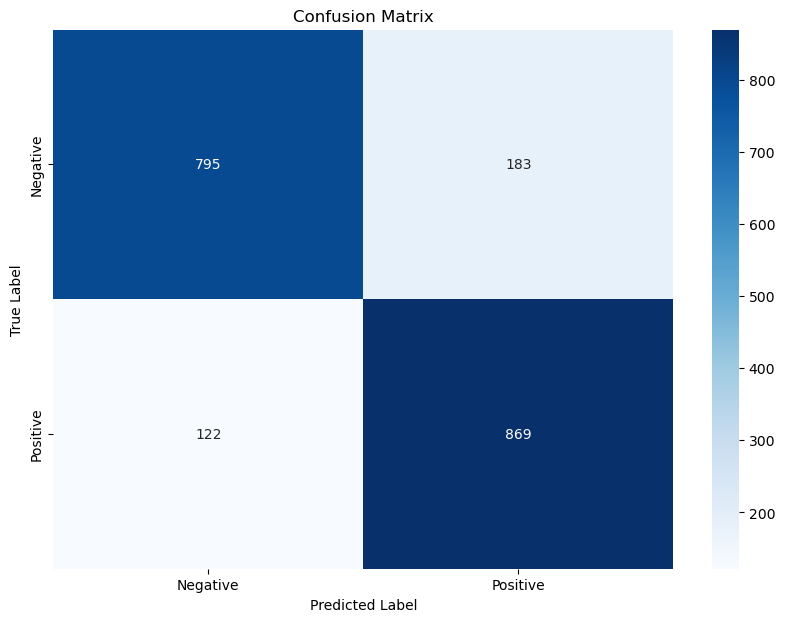


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       978
           1       0.83      0.88      0.85       991

    accuracy                           0.85      1969
   macro avg       0.85      0.84      0.84      1969
weighted avg       0.85      0.85      0.84      1969



In [30]:
# Lakukan prediksi
predictions = model_lstm.predict(X_test)
# Ubah prediksi dari one-hot encoding ke label kelas menggunakan numpy
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

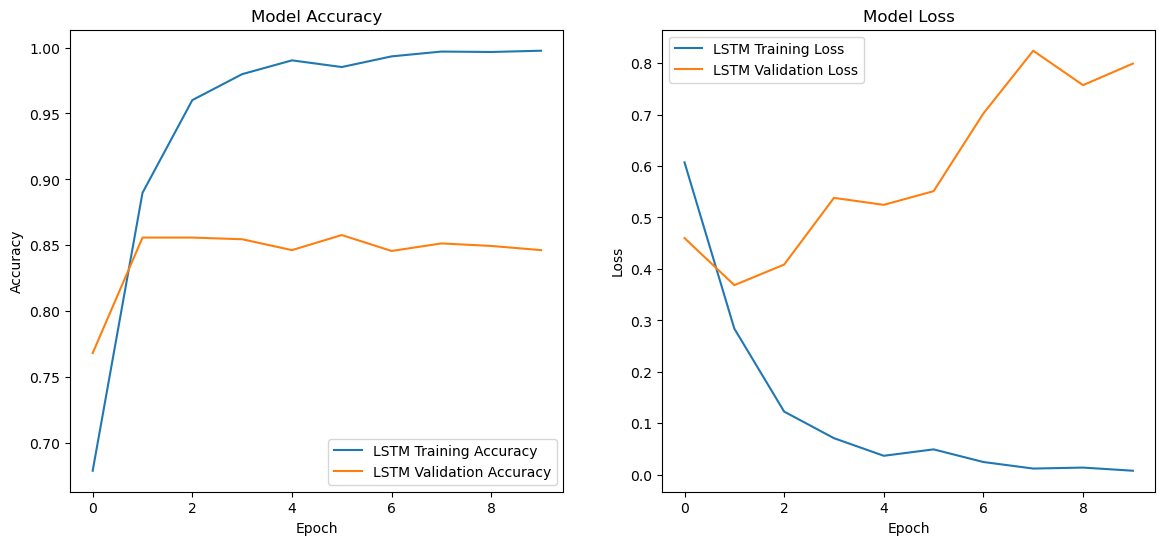

In [32]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# PSO-LSTM

In [24]:
model_pso_lstm = create_lstm_model(X_train.shape[1], y_train.shape[1], int(best_solution_pso))

start_time_pso_lstm = time.time()
history_pso_lstm = model_pso_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)
end_time_pso_lstm = time.time()
time_execution_pso_lstm = end_time_pso_lstm - start_time_pso_lstm

# Evaluasi model
loss_pso_lstm, accuracy_pso_lstm = model_pso_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_pso_lstm}")
print(f"Test Accuracy: {accuracy_pso_lstm}")
print(f"Time Execution: {time_execution_pso_lstm}")

Epoch 1/10
50/50 [==============================] - 7s 92ms/step - loss: 0.6156 - accuracy: 0.6607 - val_loss: 0.4935 - val_accuracy: 0.7613
Epoch 2/10
50/50 [==============================] - 4s 83ms/step - loss: 0.3165 - accuracy: 0.8747 - val_loss: 0.3609 - val_accuracy: 0.8533
Epoch 3/10
50/50 [==============================] - 4s 83ms/step - loss: 0.1426 - accuracy: 0.9532 - val_loss: 0.4098 - val_accuracy: 0.8616
Epoch 4/10
50/50 [==============================] - 4s 83ms/step - loss: 0.0674 - accuracy: 0.9809 - val_loss: 0.4502 - val_accuracy: 0.8654
Epoch 5/10
50/50 [==============================] - 4s 84ms/step - loss: 0.0400 - accuracy: 0.9894 - val_loss: 0.5144 - val_accuracy: 0.8654
Epoch 6/10
50/50 [==============================] - 4s 83ms/step - loss: 0.0294 - accuracy: 0.9933 - val_loss: 0.6011 - val_accuracy: 0.8648
Epoch 7/10
50/50 [==============================] - 4s 82ms/step - loss: 0.0230 - accuracy: 0.9949 - val_loss: 0.6047 - val_accuracy: 0.8514
Epoch 8/10
50

62/62 [==============================] - 1s 7ms/step


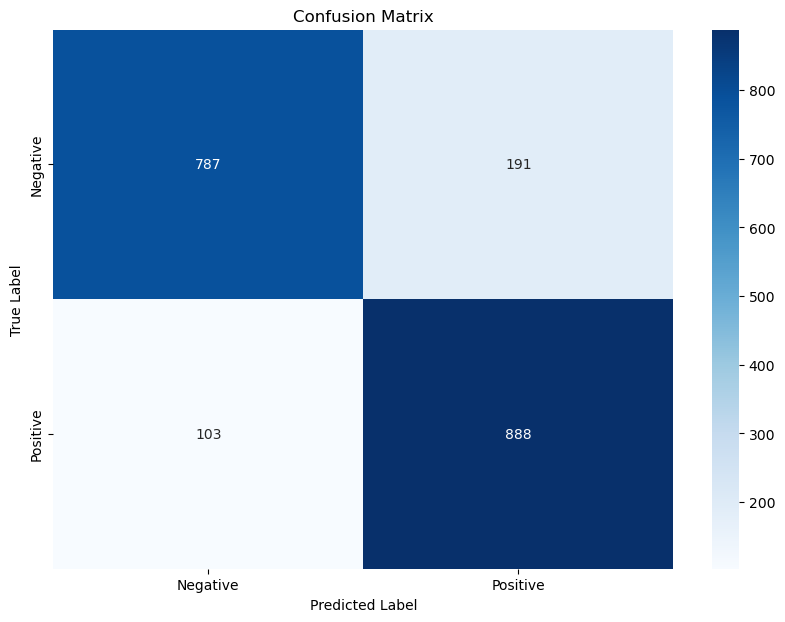


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       978
           1       0.82      0.90      0.86       991

    accuracy                           0.85      1969
   macro avg       0.85      0.85      0.85      1969
weighted avg       0.85      0.85      0.85      1969



In [29]:
# Lakukan prediksi
predictions = model_pso_lstm.predict(X_test)
# Ubah prediksi dari one-hot encoding ke label kelas menggunakan numpy
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

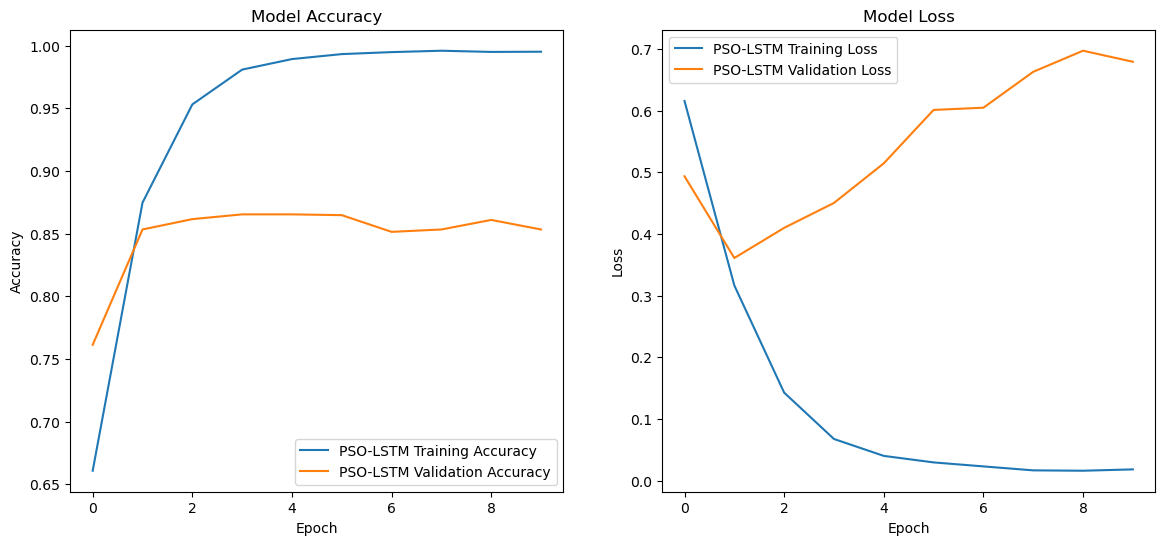

In [42]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_pso_lstm.history['accuracy'], label='PSO-LSTM Training Accuracy')
plt.plot(history_pso_lstm.history['val_accuracy'], label='PSO-LSTM Validation Accuracy')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_pso_lstm.history['loss'], label='PSO-LSTM Training Loss')
plt.plot(history_pso_lstm.history['val_loss'], label='PSO-LSTM Validation Loss')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# ACO-LSTM

In [25]:
model_aco_lstm = create_lstm_model(X_train.shape[1], y_train.shape[1], int(best_solution_aco))

start_time_aco_lstm = time.time()
history_aco_lstm = model_aco_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)
end_time_aco_lstm = time.time()
time_execution_aco_lstm = end_time_aco_lstm - start_time_aco_lstm

# Evaluasi model
loss_aco_lstm, accuracy_aco_lstm = model_aco_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_aco_lstm}")
print(f"Test Accuracy: {accuracy_aco_lstm}")
print(f"Time Execution: {time_execution_aco_lstm}")

Epoch 1/10
50/50 [==============================] - 6s 77ms/step - loss: 0.6289 - accuracy: 0.6685 - val_loss: 0.5315 - val_accuracy: 0.7232
Epoch 2/10
50/50 [==============================] - 3s 70ms/step - loss: 0.3596 - accuracy: 0.8560 - val_loss: 0.3600 - val_accuracy: 0.8546
Epoch 3/10
50/50 [==============================] - 3s 69ms/step - loss: 0.1652 - accuracy: 0.9441 - val_loss: 0.3802 - val_accuracy: 0.8540
Epoch 4/10
50/50 [==============================] - 3s 70ms/step - loss: 0.0862 - accuracy: 0.9762 - val_loss: 0.3973 - val_accuracy: 0.8603
Epoch 5/10
50/50 [==============================] - 3s 69ms/step - loss: 0.0516 - accuracy: 0.9875 - val_loss: 0.4869 - val_accuracy: 0.8540
Epoch 6/10
50/50 [==============================] - 4s 71ms/step - loss: 0.0350 - accuracy: 0.9911 - val_loss: 0.5247 - val_accuracy: 0.8597
Epoch 7/10
50/50 [==============================] - 3s 69ms/step - loss: 0.0242 - accuracy: 0.9948 - val_loss: 0.5507 - val_accuracy: 0.8565
Epoch 8/10
50

62/62 [==============================] - 0s 5ms/step


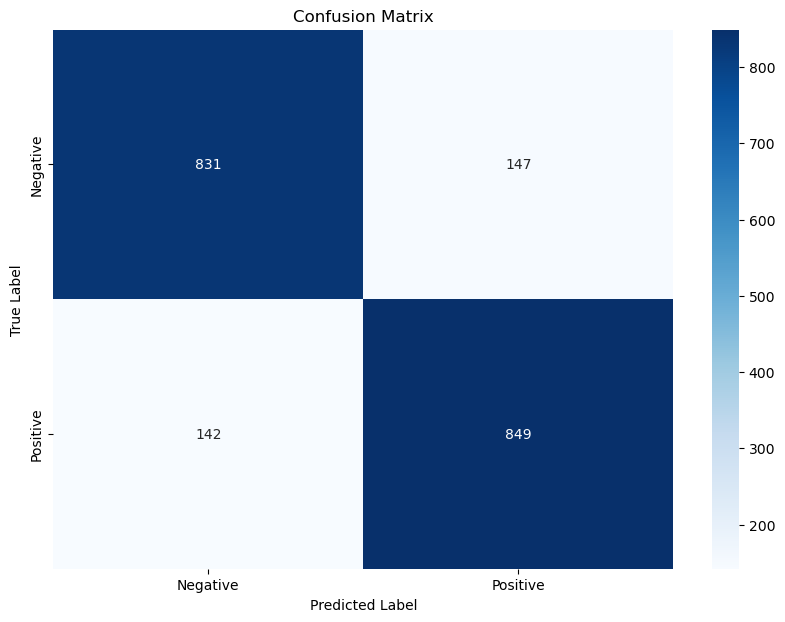


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       978
           1       0.85      0.86      0.85       991

    accuracy                           0.85      1969
   macro avg       0.85      0.85      0.85      1969
weighted avg       0.85      0.85      0.85      1969



In [28]:
# Lakukan prediksi
predictions = model_aco_lstm.predict(X_test)
# Ubah prediksi dari one-hot encoding ke label kelas menggunakan numpy
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

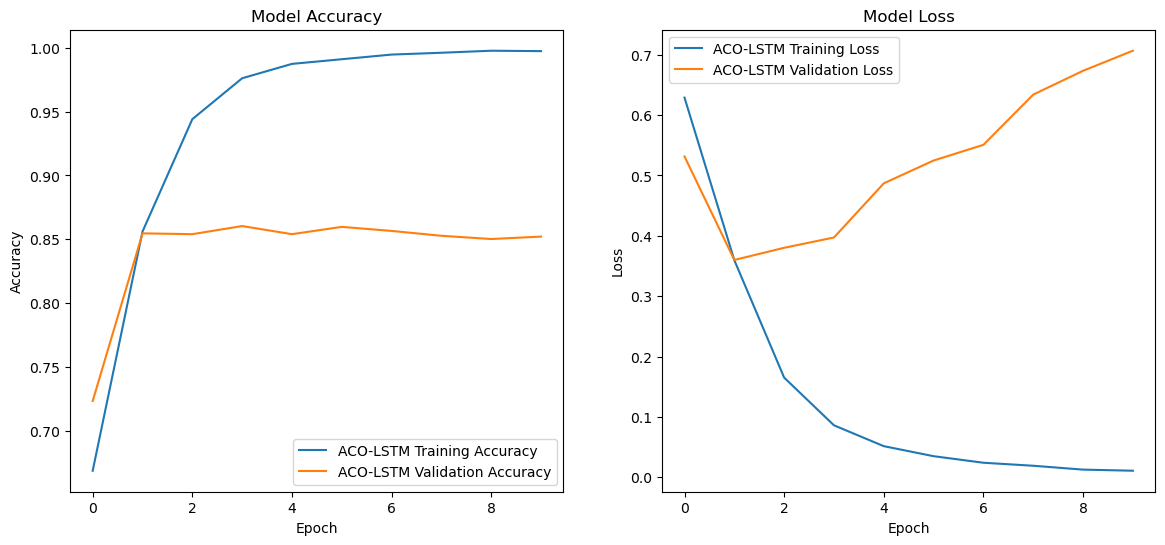

In [43]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_aco_lstm.history['accuracy'], label='ACO-LSTM Training Accuracy')
plt.plot(history_aco_lstm.history['val_accuracy'], label='ACO-LSTM Validation Accuracy')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_aco_lstm.history['loss'], label='ACO-LSTM Training Loss')
plt.plot(history_aco_lstm.history['val_loss'], label='ACO-LSTM Validation Loss')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# CSO-LSTM

In [26]:
model_cso_lstm = create_lstm_model(X_train.shape[1], y_train.shape[1], int(best_solution_cso))

start_time_cso_lstm = time.time()
history_cso_lstm = model_cso_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)
end_time_cso_lstm = time.time()
time_execution_cso_lstm = end_time_cso_lstm - start_time_cso_lstm

# Evaluasi model
loss_cso_lstm, accuracy_cso_lstm = model_cso_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_cso_lstm}")
print(f"Test Accuracy: {accuracy_cso_lstm}")
print(f"Time Execution: {time_execution_cso_lstm}")

Epoch 1/10
50/50 [==============================] - 11s 167ms/step - loss: 0.5886 - accuracy: 0.6880 - val_loss: 0.4458 - val_accuracy: 0.7975
Epoch 2/10
50/50 [==============================] - 8s 169ms/step - loss: 0.2863 - accuracy: 0.8901 - val_loss: 0.3574 - val_accuracy: 0.8571
Epoch 3/10
50/50 [==============================] - 8s 166ms/step - loss: 0.1322 - accuracy: 0.9559 - val_loss: 0.3957 - val_accuracy: 0.8565
Epoch 4/10
50/50 [==============================] - 8s 170ms/step - loss: 0.0700 - accuracy: 0.9797 - val_loss: 0.4813 - val_accuracy: 0.8533
Epoch 5/10
50/50 [==============================] - 8s 168ms/step - loss: 0.0421 - accuracy: 0.9883 - val_loss: 0.5757 - val_accuracy: 0.8571
Epoch 6/10
50/50 [==============================] - 8s 167ms/step - loss: 0.0261 - accuracy: 0.9929 - val_loss: 0.7031 - val_accuracy: 0.8508
Epoch 7/10
50/50 [==============================] - 9s 171ms/step - loss: 0.0225 - accuracy: 0.9938 - val_loss: 0.6793 - val_accuracy: 0.8533
Epoch

62/62 [==============================] - 1s 18ms/step


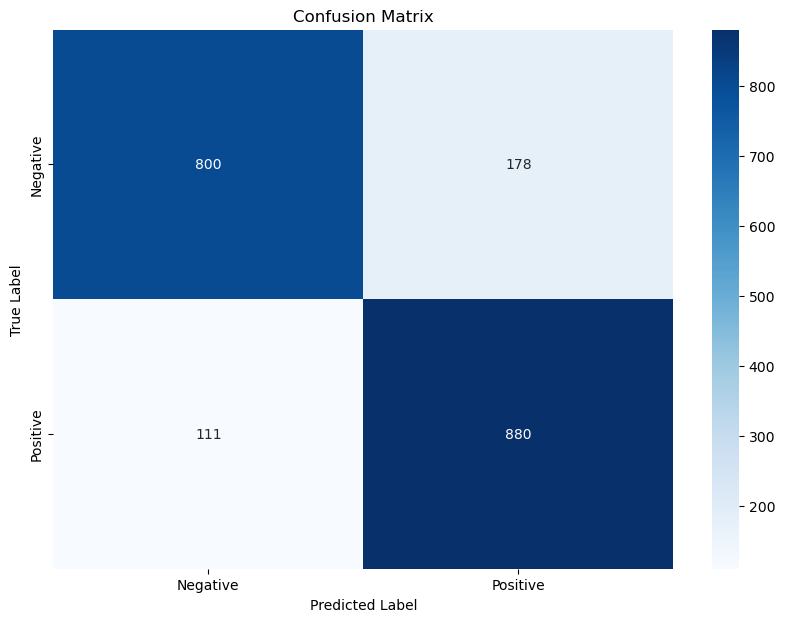


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       978
           1       0.83      0.89      0.86       991

    accuracy                           0.85      1969
   macro avg       0.85      0.85      0.85      1969
weighted avg       0.85      0.85      0.85      1969



In [27]:
# Lakukan prediksi
predictions = model_cso_lstm.predict(X_test)
# Ubah prediksi dari one-hot encoding ke label kelas menggunakan numpy
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

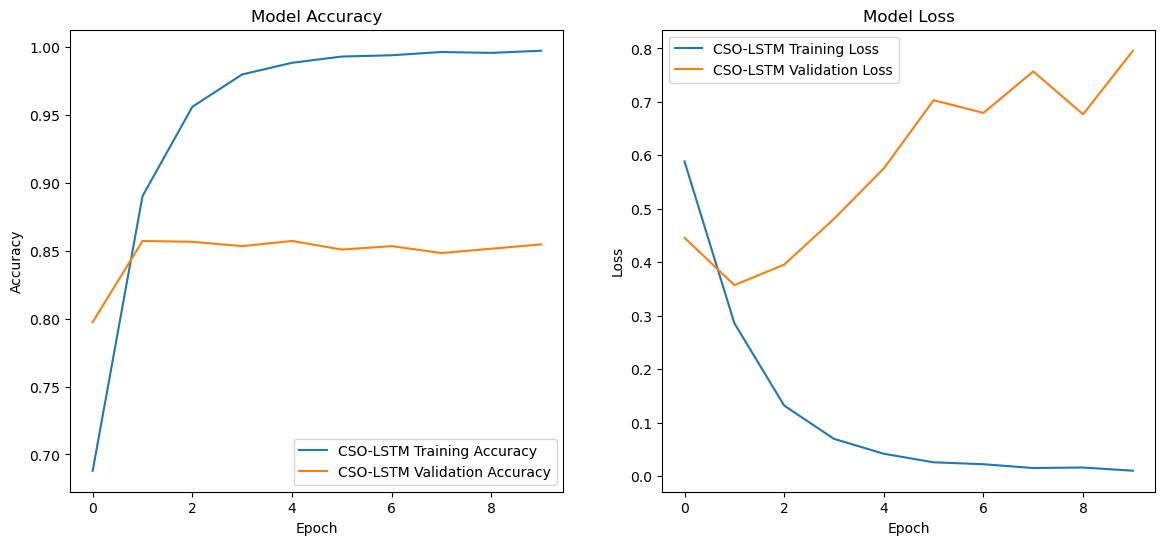

In [44]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cso_lstm.history['accuracy'], label='CSO-LSTM Training Accuracy')
plt.plot(history_cso_lstm.history['val_accuracy'], label='CSO-LSTM Validation Accuracy')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cso_lstm.history['loss'], label='CSO-LSTM Training Loss')
plt.plot(history_cso_lstm.history['val_loss'], label='CSO-LSTM Validation Loss')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# **Evaluation**

In [62]:
# Data hasil eksperimen
results = {
    "Model": ["LSTM", "PSO-LSTM", "ACO-LSTM", "CSO-LSTM"],
    "Num LSTM Units": [256, int(best_solution_pso[0]), int(best_solution_aco), int(best_solution_cso)],
    "Test Loss": [loss_lstm, loss_pso_lstm, loss_aco_lstm, loss_cso_lstm],
    "Test Accuracy": [accuracy_lstm, accuracy_pso_lstm, accuracy_aco_lstm, accuracy_cso_lstm],
    "Execution Time (s)": [time_execution_lstm, time_execution_pso_lstm, time_execution_aco_lstm, time_execution_cso_lstm]
}

# Membuat DataFrame
results_df = pd.DataFrame(results)

# Menampilkan tabel
print(results_df)

      Model  Num LSTM Units  Test Loss  Test Accuracy  Execution Time (s)
0      LSTM             256   0.862592       0.845099           93.573139
1  PSO-LSTM              53   0.755617       0.850686           44.250771
2  ACO-LSTM              33   0.722810       0.853225           37.411491
3  CSO-LSTM             244   0.850528       0.853225           86.940012


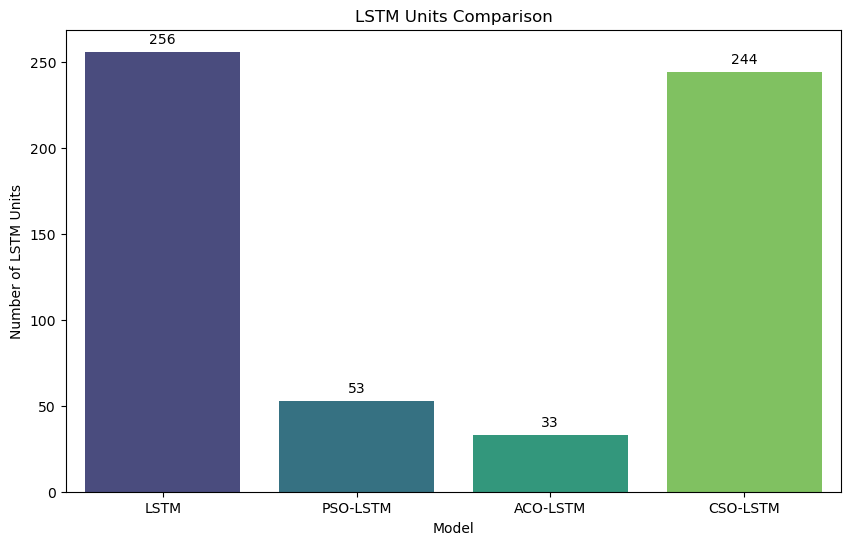

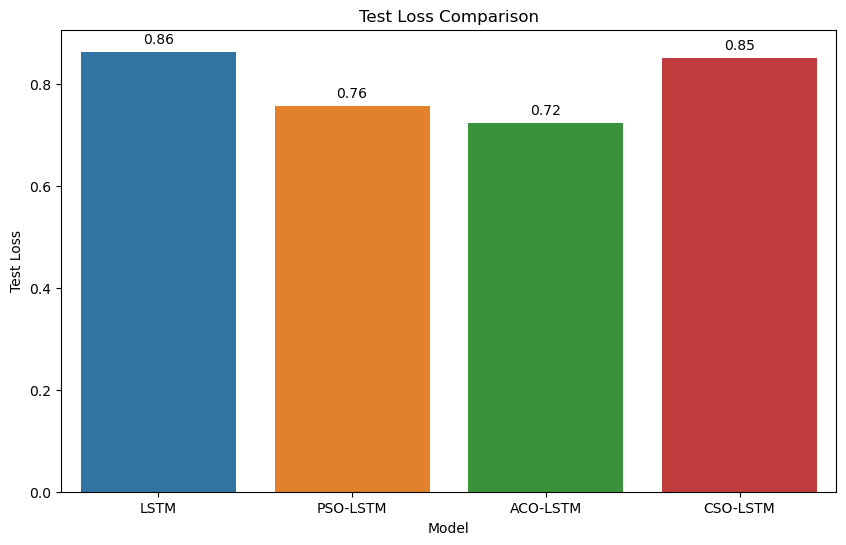

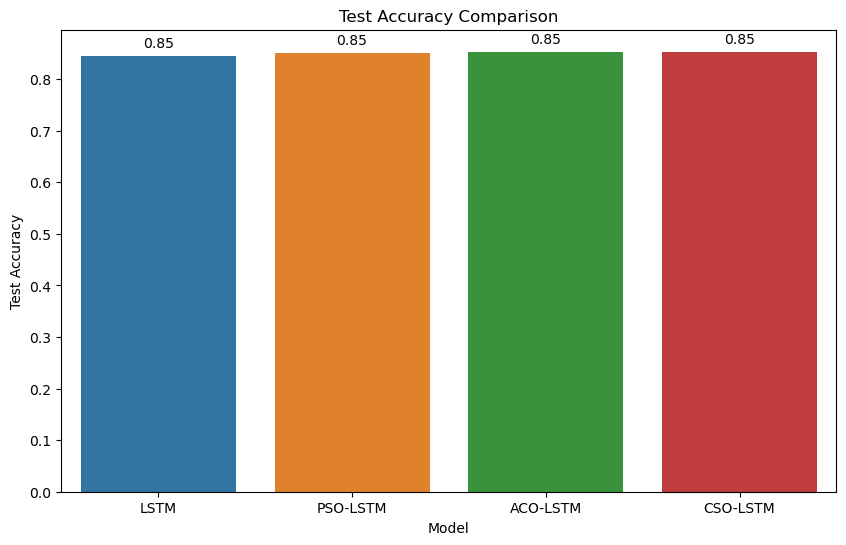

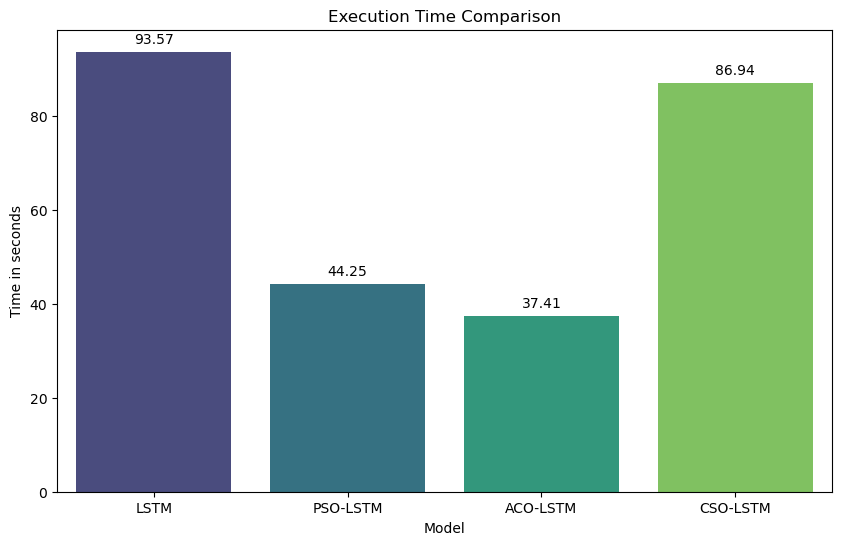

In [63]:
# Num LSTM Units
plt.figure(figsize=(10, 6))
barplot_units = sns.barplot(x='Model', y="Num LSTM Units", palette="viridis", data=results_df)
plt.title('LSTM Units Comparison')
plt.ylabel('Number of LSTM Units')
plt.xlabel('Model')
for p in barplot_units.patches:
    barplot_units.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points')
plt.show()

# Loss
plt.figure(figsize=(10, 6))
barplot_loss = sns.barplot(x='Model', y='Test Loss', data=results_df)
plt.title('Test Loss Comparison')
for p in barplot_loss.patches:
    barplot_loss.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.show()

# Akurasi
plt.figure(figsize=(10, 6))
barplot_acc = sns.barplot(x='Model', y='Test Accuracy', data=results_df)
plt.title('Test Accuracy Comparison')
for p in barplot_acc.patches:
    barplot_acc.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
plt.show()

# Execution Time
plt.figure(figsize=(10, 6))
barplot_time = sns.barplot(x='Model', y="Execution Time (s)", palette="viridis", data=results_df)
plt.title('Execution Time Comparison')
plt.ylabel('Time in seconds')
plt.xlabel('Model')
for p in barplot_time.patches:
    barplot_time.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.show()

In [66]:
# Menentukan model terbaik berdasarkan kriteria
# Urutkan dulu berdasarkan 'Test Accuracy' tertinggi, kemudian 'Test Loss' terendah, dan akhirnya 'Execution Time (s)' tercepat
best_model = results_df.sort_values(by=['Test Accuracy', 'Test Loss', 'Execution Time (s)'], ascending=[False, True, True])

best_model #paling bagus di atas

,Model,Num LSTM Units,Test Loss,Test Accuracy,Execution Time (s)
2,ACO-LSTM,33,0.722810,0.853225,37.411491
3,CSO-LSTM,244,0.850528,0.853225,86.940012
1,PSO-LSTM,53,0.755617,0.850686,44.250771
0,LSTM,256,0.862592,0.845099,93.573139


# Uji Statistik

In [86]:
val_accuracies_lstm = history_lstm.history['val_accuracy']
print(f"Val accuracy LSTM: {val_accuracies_lstm}")

val_accuracies_pso_lstm = history_pso_lstm.history['val_accuracy']
print(f"Val accuracy PSO-LSTM: {val_accuracies_pso_lstm}")

val_accuracies_aco_lstm = history_aco_lstm.history['val_accuracy']
print(f"Val accuracy ACO-LSTM: {val_accuracies_lstm}")

val_accuracies_cso_lstm = history_cso_lstm.history['val_accuracy']
print(f"Val accuracy CSO-LSTM: {val_accuracies_lstm}")

Val accuracy LSTM: [0.7682539820671082, 0.8558729887008667, 0.8558729887008667, 0.8546031713485718, 0.8463491797447205, 0.8577777743339539, 0.845714271068573, 0.8514285683631897, 0.8495237827301025, 0.8463491797447205]
Val accuracy PSO-LSTM: [0.7612698674201965, 0.8533333539962769, 0.8615872859954834, 0.8653967976570129, 0.8653967976570129, 0.8647618889808655, 0.8514285683631897, 0.8533333539962769, 0.8609523773193359, 0.8533333539962769]
Val accuracy ACO-LSTM: [0.7682539820671082, 0.8558729887008667, 0.8558729887008667, 0.8546031713485718, 0.8463491797447205, 0.8577777743339539, 0.845714271068573, 0.8514285683631897, 0.8495237827301025, 0.8463491797447205]
Val accuracy CSO-LSTM: [0.7682539820671082, 0.8558729887008667, 0.8558729887008667, 0.8546031713485718, 0.8463491797447205, 0.8577777743339539, 0.845714271068573, 0.8514285683631897, 0.8495237827301025, 0.8463491797447205]


In [97]:
from scipy.stats import shapiro

# Data akurasi contoh untuk 4 model (5 akurasi terkahir saat validation)
accuracies = {
    "LSTM": [0.8577777743339539, 0.845714271068573, 0.8514285683631897, 0.8495237827301025, 0.8463491797447205],
    "PSO-LSTM": [0.8647618889808655, 0.8514285683631897, 0.8533333539962769, 0.8609523773193359, 0.8533333539962769],
    "ACO-LSTM": [0.8577777743339539, 0.845714271068573, 0.8514285683631897, 0.8495237827301025, 0.8463491797447205],
    "CSO-LSTM": [0.8577777743339539, 0.845714271068573, 0.8514285683631897, 0.8495237827301025, 0.8463491797447205]
}

# Cek normalitas untuk setiap model
for model, scores in accuracies.items():
    stat, p = shapiro(scores)
    print(f"{model}: Statistics={stat:.3f}, p={p:.3f}")
    if p > 0.05:
        print("Sample looks Gaussian (normal distribution).")
    else:
        print("Sample does not look Gaussian (non-normal distribution).")

LSTM: Statistics=0.906, p=0.443
Sample looks Gaussian (normal distribution).
PSO-LSTM: Statistics=0.858, p=0.220
Sample looks Gaussian (normal distribution).
ACO-LSTM: Statistics=0.906, p=0.443
Sample looks Gaussian (normal distribution).
CSO-LSTM: Statistics=0.906, p=0.443
Sample looks Gaussian (normal distribution).


In [98]:
from scipy.stats import f_oneway

# Ekstrak nilai akurasi
accuracy_values = list(accuracies.values())

# Uji ANOVA
stat, p = f_oneway(*accuracy_values)
print(f"ANOVA test: Statistics={stat:.3f}, p={p:.3f}")
if p > 0.05:
    print("Tidak ada perbedaan yang signifikan.")
else:
    print("Ada perbedaan yang signifikan.")

ANOVA test: Statistics=2.094, p=0.141
Tidak ada perbedaan yang signifikan.


In [99]:
from scipy.stats import kruskal

# Uji Kruskal-Wallis
stat, p = kruskal(*accuracy_values)
print(f"Kruskal-Wallis test: Statistics={stat:.3f}, p={p:.3f}")
if p > 0.05:
    print("Tidak ada perbedaan yang signifikan.")
else:
    print("Ada perbedaan yang signifikan.")

Kruskal-Wallis test: Statistics=5.669, p=0.129
Tidak ada perbedaan yang signifikan.
